# ECE 219 Project 2 — Student B
## Part 2: Deep Learning & Image Clustering (Q13–Q19)
## Part 1 Task 3: Held-Out Steam Game Profiling (Q9–Q12)

In [1]:
import os
import tarfile
import requests
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, HDBSCAN
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import (
    homogeneity_score, completeness_score, v_measure_score,
    adjusted_rand_score, adjusted_mutual_info_score
)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import umap

# Global device — uses Apple Silicon MPS if available, else CPU
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: mps


---
# PART 2 — Deep Learning and Clustering of Image Data

## Q13 — Transfer Learning: Why VGG Features Generalize

Although VGG-16 was trained on ImageNet (1,000 object categories), its intermediate layers learn general-purpose visual representations rather than ImageNet-specific ones. The convolutional layers in the feature extractor progressively build a hierarchy of visual primitives:
- **Early layers** detect low-level features such as edges, corners, color gradients, and textures — primitives that appear in any natural image regardless of the object class.
- **Middle layers** compose those primitives into part-level detectors (e.g., curves, repeating textures, blobs of colour).
- **Deeper layers** encode object-part combinations (e.g., petal-like shapes, circular disk patterns, or fine-grained textures) that are highly descriptive even for categories never seen during training.

This hierarchy of learned features is transferable because the visual world shares statistical structure across datasets. When we feed flower images through VGG-16 and extract the 4,096-dimensional activations of the first fully-connected layer, we obtain a rich, compact description of each image in terms of those reusable visual concepts. Different flower species differ visibly in shape, color distribution, petal arrangement, and texture — all properties that the VGG feature space encodes well. Even though no flower class appeared during training, the features discriminate between species because the underlying visual primitives do.

This is the core principle of **transfer learning**: a deep network trained on a large, diverse dataset captures general visual knowledge that can be directly leveraged as feature engineering for downstream tasks, saving the cost of training from scratch on a smaller dataset.

## Feature Extraction — VGG-16 on Flowers Dataset

In [2]:
# ─── VGG-16 Feature Extractor (adapted for MPS / CPU) ─────────────────────────
class FeatureExtractor(nn.Module):
    """Extracts the 4096-dim activation from VGG-16's first FC layer."""

    def __init__(self):
        super().__init__()
        vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
        self.features = vgg.features          # conv blocks
        self.pooling  = vgg.avgpool            # adaptive avg pool → 7×7
        self.flatten  = nn.Flatten()
        self.fc       = vgg.classifier[0]      # Linear(25088 → 4096)

    def forward(self, x):
        out = self.features(x)
        out = self.pooling(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out


FLOWERS_NPZ = './flowers_features_and_labels.npz'

if os.path.exists(FLOWERS_NPZ):
    print('Loading cached VGG features…')
    file  = np.load(FLOWERS_NPZ)
    f_all = file['f_all']
    y_all = file['y_all'].astype(int)
    class_names = list(file['class_names']) if 'class_names' in file else\
                  ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
else:
    # ── Download dataset if needed ────────────────────────────────────────────
    if not os.path.exists('./flower_photos'):
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        print('Downloading flowers dataset…')
        with open('./flower_photos.tgz', 'wb') as fh:
            fh.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as fh:
            fh.extractall('./')
        os.remove('./flower_photos.tgz')
        print('Download complete.')

    # ── Build dataset & dataloader ───────────────────────────────────────────
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std =[0.229, 0.224, 0.225]),
    ])
    dataset     = datasets.ImageFolder(root='./flower_photos', transform=transform)
    class_names = dataset.classes           # alphabetically sorted
    dataloader  = DataLoader(dataset, batch_size=64, shuffle=False)

    # ── Extract features ──────────────────────────────────────────────────────
    print(f'Extracting VGG-16 features on {DEVICE}…')
    extractor = FeatureExtractor().to(DEVICE).eval()
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,), dtype=int)
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            feats = extractor(x.to(DEVICE)).cpu().numpy()
        f_all = np.vstack([f_all, feats])
        y_all = np.concatenate([y_all, y.numpy()])

    np.savez(FLOWERS_NPZ, f_all=f_all, y_all=y_all,
             class_names=np.array(class_names))
    print('Features saved.')

NUM_FEATURES = f_all.shape[1]
N_CLASSES    = len(np.unique(y_all))
print(f'Feature matrix: {f_all.shape}  |  Classes: {N_CLASSES}  |  Labels: {class_names}')

Download complete.
Extracting VGG-16 features on mps…
Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /Users/iseanbhanot/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/iseanbhanot/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [01:01<00:00, 9.02MB/s] 
100%|██████████| 58/58 [00:44<00:00,  1.29it/s]

Features saved.
Feature matrix: (3670, 4096)  |  Classes: 5  |  Labels: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Q14 — How the Helper Code Performs Feature Extraction

The helper code performs feature extraction in four steps:

1. **Load pre-trained VGG-16** (`torch.hub.load`). The full VGG-16 network trained on ImageNet is downloaded. It consists of 13 convolutional layers (`vgg.features`), a global average-pooling layer (`vgg.avgpool`), and a three-layer fully-connected classifier (`vgg.classifier`).

2. **Surgical truncation**: the `FeatureExtractor` module keeps only `features`, `avgpool`, a `Flatten`, and the *first* FC layer (`classifier[0]`, a `Linear(25088 → 4096)`). The remaining FC layers and the final softmax are discarded. This retains the rich learned representation but drops the ImageNet-specific classification head.

3. **Pre-processing images**: every flower image is resized to 224×224 pixels, converted to a float tensor, and channel-normalized with ImageNet statistics (`mean=[0.485, 0.456, 0.406]`, `std=[0.229, 0.224, 0.225]`). This matches the distribution the network was trained on.

4. **Batch inference**: images are loaded in mini-batches of 64 and passed through the truncated network under `torch.no_grad()` (no gradient computation). The 4,096-dimensional activation vectors are collected and concatenated into a matrix `f_all` of shape `(N_images, 4096)` which is cached to disk for reuse.

## Q15 — Pixel Count vs. Feature Dimension

In [3]:
# Original image sizes vary; after the Resize(224) + CenterCrop(224) pre-processing
# every image fed to VGG is exactly 224×224 with 3 RGB channels.

PROCESSED_H, PROCESSED_W, CHANNELS = 224, 224, 3
pixels_processed = PROCESSED_H * PROCESSED_W * CHANNELS

# Check actual original image sizes from the folder (sample the first 10 images)
if os.path.exists('./flower_photos'):
    from PIL import Image
    sizes = []
    for root, dirs, files in os.walk('./flower_photos'):
        for fname in files:
            if fname.lower().endswith(('.jpg', '.jpeg')):
                img = Image.open(os.path.join(root, fname))
                sizes.append(img.size)  # (width, height)
                if len(sizes) >= 50:
                    break
        if len(sizes) >= 50:
            break
    widths  = [s[0] for s in sizes]
    heights = [s[1] for s in sizes]
    print(f'Sample of original image sizes (first 50):')
    print(f'  Width  — min: {min(widths)}, max: {max(widths)}, mean: {np.mean(widths):.0f}')
    print(f'  Height — min: {min(heights)}, max: {max(heights)}, mean: {np.mean(heights):.0f}')
    avg_orig_pixels = int(np.mean(widths) * np.mean(heights) * 3)
    print(f'  Approximate avg pixels (RGB) in originals: {avg_orig_pixels:,}')

print(f'\nAfter pre-processing (224×224×3):')
print(f'  Pixels per image fed to VGG : {pixels_processed:,}  ({PROCESSED_H}×{PROCESSED_W}×{CHANNELS})')
print(f'  VGG feature dimension       : {NUM_FEATURES:,}')
print(f'  Compression ratio           : {pixels_processed / NUM_FEATURES:.1f}×')

Sample of original image sizes (first 50):
  Width  — min: 159, max: 640, mean: 373
  Height — min: 213, max: 375, mean: 276
  Approximate avg pixels (RGB) in originals: 309,502

After pre-processing (224×224×3):
  Pixels per image fed to VGG : 150,528  (224×224×3)
  VGG feature dimension       : 4,096
  Compression ratio           : 36.8×


## Q16 — Are VGG Features Dense or Sparse?

In [4]:
zero_frac  = (f_all == 0).mean()
near0_frac = (np.abs(f_all) < 1e-3).mean()

print('=== VGG Feature Density Analysis ===')
print(f'Feature matrix shape : {f_all.shape}')
print(f'Exact zeros          : {zero_frac*100:.2f}%')
print(f'Near-zero (<1e-3)    : {near0_frac*100:.2f}%')
print()
print('The VGG features are DENSE.')
print('Almost every entry is a non-zero real-valued activation produced by')
print('ReLU + fully-connected layers — unlike TF-IDF which is structurally sparse')
print('because most words simply do not appear in a given document.')

=== VGG Feature Density Analysis ===
Feature matrix shape : (3670, 4096)
Exact zeros          : 0.00%
Near-zero (<1e-3)    : 0.03%

The VGG features are DENSE.
Almost every entry is a non-zero real-valued activation produced by
ReLU + fully-connected layers — unlike TF-IDF which is structurally sparse
because most words simply do not appear in a given document.


## Q17 — t-SNE Visualization of VGG Features

Pre-reducing to 50 dims with PCA before t-SNE…
Running t-SNE (this may take ~1-2 minutes)…


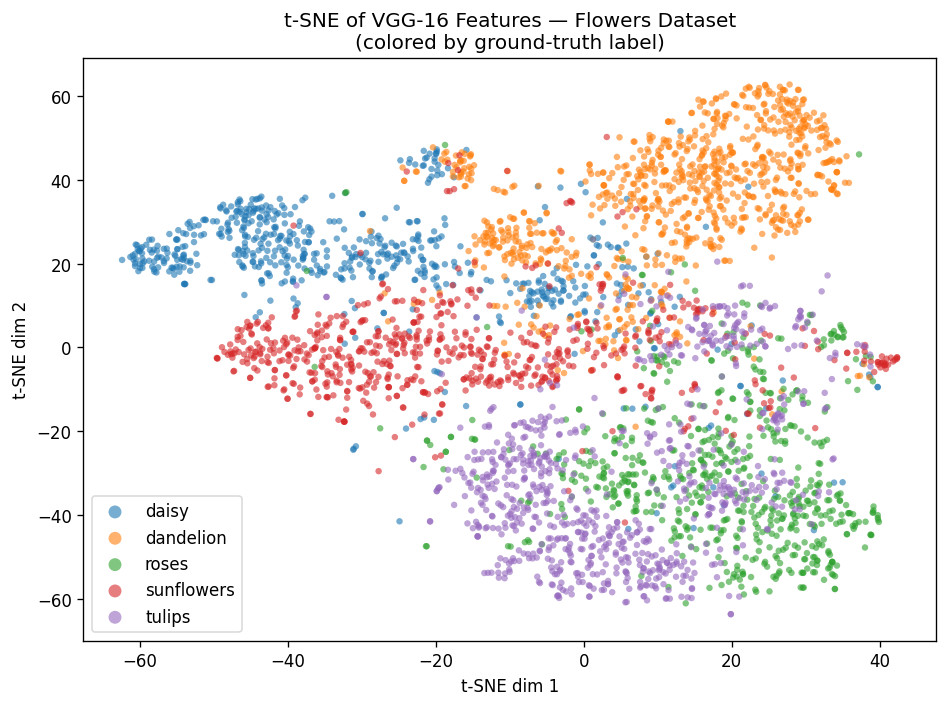

Saved: q17_tsne_vgg_flowers.png


In [6]:
# t-SNE on full 4096-dim features.
# PCA pre-reduction to 50 dims speeds up t-SNE significantly.
print('Pre-reducing to 50 dims with PCA before t-SNE…')
f_pca50 = PCA(n_components=50, random_state=42).fit_transform(
    StandardScaler().fit_transform(f_all)
)

print('Running t-SNE (this may take ~1-2 minutes)…')
tsne   = TSNE(n_components=2, perplexity=30, max_iter=1000,
              learning_rate='auto', init='pca', random_state=42)
f_tsne = tsne.fit_transform(f_pca50)

CMAP   = plt.get_cmap('tab10')
COLORS = [CMAP(i) for i in range(N_CLASSES)]

fig, ax = plt.subplots(figsize=(8, 6))
for cls_idx, cls_name in enumerate(class_names):
    mask = y_all == cls_idx
    ax.scatter(f_tsne[mask, 0], f_tsne[mask, 1],
               c=[COLORS[cls_idx]], label=cls_name,
               alpha=0.6, s=15, edgecolors='none')
ax.set_title('t-SNE of VGG-16 Features — Flowers Dataset\n(colored by ground-truth label)')
ax.set_xlabel('t-SNE dim 1')
ax.set_ylabel('t-SNE dim 2')
ax.legend(markerscale=2, framealpha=0.7)
plt.tight_layout()
plt.savefig('q17_tsne_vgg_flowers.png', bbox_inches='tight')
plt.show()
print('Saved: q17_tsne_vgg_flowers.png')

## Q18 — Clustering Pipeline Table (best ARI)

All 4 dimensionality-reduction × 3 clustering combinations are evaluated.
HDBSCAN uses a conservative grid over `min_cluster_size` and `min_samples`.

In [7]:
# ─── Autoencoder (adapted from helper — uses DEVICE) ──────────────────────────
class Autoencoder(nn.Module):
    """Trains on 4096-dim VGG features and reduces to n_components dims."""

    def __init__(self, n_components=50):
        super().__init__()
        self.n_components = n_components
        self.encoder = nn.Sequential(
            nn.Linear(4096, 1280), nn.ReLU(True),
            nn.Linear(1280,  640), nn.ReLU(True),
            nn.Linear( 640,  120), nn.ReLU(True),
            nn.Linear( 120, n_components),
        )
        self.decoder = nn.Sequential(
            nn.Linear(n_components, 120), nn.ReLU(True),
            nn.Linear( 120,  640), nn.ReLU(True),
            nn.Linear( 640, 1280), nn.ReLU(True),
            nn.Linear(1280, 4096),
        )
        self.to(DEVICE)

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def fit(self, X, epochs=100, batch_size=128, lr=1e-3):
        X_t   = torch.tensor(X, dtype=torch.float32)
        loader = DataLoader(TensorDataset(X_t), batch_size=batch_size, shuffle=True)
        crit  = nn.MSELoss()
        optim = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=1e-5)
        self.train()
        for _ in tqdm(range(epochs), desc='Autoencoder'):
            for (xb,) in loader:
                xb = xb.to(DEVICE)
                optim.zero_grad()
                crit(self(xb), xb).backward()
                optim.step()
        return self

    def transform(self, X):
        self.eval()
        with torch.no_grad():
            return self.encoder(
                torch.tensor(X, dtype=torch.float32, device=DEVICE)
            ).cpu().numpy()

    def fit_transform(self, X, **kw):
        return self.fit(X, **kw).transform(X)

In [8]:
# ─── Pre-compute all dimensionality-reduced feature sets ──────────────────────

scaler = StandardScaler()
f_scaled = scaler.fit_transform(f_all)

DR_CACHE = {}  # reduction_name → reduced features

# 1. None — use scaled full features
print('[1/4] No reduction (4096 dims, scaled)…')
DR_CACHE['None'] = f_scaled

# 2. SVD (r=50)
print('[2/4] SVD r=50…')
DR_CACHE['SVD(50)'] = TruncatedSVD(n_components=50, random_state=42).fit_transform(f_scaled)

# 3. UMAP (n_components=50) — first SVD to 200, then UMAP
print('[3/4] SVD(200) → UMAP(50)…')
f_svd200 = TruncatedSVD(n_components=200, random_state=42).fit_transform(f_scaled)
DR_CACHE['UMAP(50)'] = umap.UMAP(
    n_components=50, n_neighbors=15, min_dist=0.1, random_state=42
).fit_transform(f_svd200)

# 4. Autoencoder (latent_dim=50)
print('[4/4] Autoencoder(50)…')
ae = Autoencoder(n_components=50)
DR_CACHE['AE(50)'] = ae.fit_transform(f_scaled)

print('All reductions done.')

[1/4] No reduction (4096 dims, scaled)…
[2/4] SVD r=50…
[3/4] SVD(200) → UMAP(50)…
[4/4] Autoencoder(50)…


Autoencoder: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


All reductions done.


In [ ]:
# ─── Clustering evaluation helper ─────────────────────────────────────────────
def eval_clustering(labels_true, labels_pred):
    """Returns dict of clustering metrics (ignores noise label -1)."""
    # For HDBSCAN noise points are labeled -1 — exclude them from evaluation
    mask = labels_pred != -1
    lt   = labels_true[mask]
    lp   = labels_pred[mask]
    if len(np.unique(lp)) < 2:
        return dict(homogeneity=0, completeness=0, v_measure=0, ARI=0, AMI=0,
                    n_clusters=1, noise_frac=1 - mask.mean())
    return dict(
        homogeneity  = homogeneity_score(lt, lp),
        completeness = completeness_score(lt, lp),
        v_measure    = v_measure_score(lt, lp),
        ARI          = adjusted_rand_score(lt, lp),
        AMI          = adjusted_mutual_info_score(lt, lp),
        n_clusters   = len(np.unique(lp)),
        noise_frac   = 1 - mask.mean(),
    )


def run_kmeans(Z, k=5):
    return KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(Z)


def run_agglomerative(Z, k=5, n_neighbors=10):
    conn  = kneighbors_graph(Z, n_neighbors=n_neighbors,
                             mode='connectivity', include_self=False)
    return AgglomerativeClustering(
        n_clusters=k, linkage='ward', connectivity=conn
    ).fit_predict(Z)


# ─── HDBSCAN grid for best ARI ────────────────────────────────────────────────
HDBSCAN_GRID = [
    (mcs, ms)
    for mcs in [5, 10, 15, 20]
    for ms  in [3, 5, 10]
]

def run_best_hdbscan(Z, y_true):
    best, best_labels = {'ARI': -1}, None
    for mcs, ms in HDBSCAN_GRID:
        labels = HDBSCAN(min_cluster_size=mcs, min_samples=ms).fit_predict(Z)
        m = eval_clustering(y_true, labels)
        if m['ARI'] > best['ARI']:
            best = m | {'min_cluster_size': mcs, 'min_samples': ms}
            best_labels = labels
    return best, best_labels


# ─── Run all pipelines ────────────────────────────────────────────────────────
results = []
y_true  = y_all

for dr_name, Z in DR_CACHE.items():
    print(f'\n--- {dr_name} ---')

    # K-Means
    labels = run_kmeans(Z)
    m = eval_clustering(y_true, labels)
    results.append({'Reduction': dr_name, 'Clustering': 'K-Means(5)',
                    **m, 'notes': ''})
    print(f'  K-Means   ARI={m["ARI"]:.3f}')

    # Agglomerative
    labels = run_agglomerative(Z)
    m = eval_clustering(y_true, labels)
    results.append({'Reduction': dr_name, 'Clustering': 'Agglom.(5)',
                    **m, 'notes': ''})
    print(f'  Agglom.   ARI={m["ARI"]:.3f}')

    # HDBSCAN
    m, _ = run_best_hdbscan(Z, y_true)
    results.append({'Reduction': dr_name, 'Clustering': 'HDBSCAN',
                    **m,
                    'notes': f'mcs={m.get("min_cluster_size","?")},ms={m.get("min_samples","?")}'})
    print(f'  HDBSCAN   ARI={m["ARI"]:.3f}  (mcs={m.get("min_cluster_size")},ms={m.get("min_samples")})')

print('\nAll pipelines complete.')


--- None ---
  K-Means   ARI=0.191
  Agglom.   ARI=0.229


In [ ]:
# ─── Display results table ────────────────────────────────────────────────────
results_df = pd.DataFrame(results)
display_cols = ['Reduction', 'Clustering', 'n_clusters', 'noise_frac',
                'homogeneity', 'completeness', 'v_measure', 'ARI', 'AMI', 'notes']
tbl = results_df[display_cols].copy()
float_cols = ['noise_frac', 'homogeneity', 'completeness', 'v_measure', 'ARI', 'AMI']
tbl[float_cols] = tbl[float_cols].map(lambda x: f'{x:.3f}' if isinstance(x, float) else x)

print('\nQ18 — Clustering Results (sorted by ARI descending)\n')
print(tbl.sort_values('ARI', ascending=False).to_string(index=False))

# Best pipeline
best_row = results_df.loc[results_df['ARI'].idxmax()]
print(f'\n★ Best pipeline: {best_row["Reduction"]} + {best_row["Clustering"]}')
print(f'  ARI = {best_row["ARI"]:.4f}  |  V-measure = {best_row["v_measure"]:.4f}')

## Q19 — MLP Classifier on Original and Reduced VGG Features

In [ ]:
# ─── MLP Classifier ───────────────────────────────────────────────────────────
class MLP(nn.Module):
    def __init__(self, num_features, num_classes=5):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, num_classes),
            nn.LogSoftmax(dim=1),
        )
        self.to(DEVICE)

    def forward(self, x):
        return self.model(x)

    def fit(self, X_train, y_train, epochs=100, batch_size=128):
        Xt = torch.tensor(X_train, dtype=torch.float32)
        yt = torch.tensor(y_train, dtype=torch.int64)
        loader = DataLoader(TensorDataset(Xt, yt),
                            batch_size=batch_size, shuffle=True)
        crit  = nn.NLLLoss()
        optim = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        self.model.train()
        for _ in tqdm(range(epochs), desc='MLP training'):
            for xb, yb in loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                optim.zero_grad()
                crit(self(xb), yb).backward()
                optim.step()
        return self

    def score(self, X_test, y_test):
        self.model.eval()
        Xt = torch.tensor(X_test, dtype=torch.float32, device=DEVICE)
        yt = torch.tensor(y_test, dtype=torch.int64, device=DEVICE)
        with torch.no_grad():
            preds = self(Xt).argmax(dim=1)
        return (preds == yt).float().mean().item()

In [ ]:
# ─── Train/test split (stratified 80/20) ─────────────────────────────────────
idx_tr, idx_te = train_test_split(
    np.arange(len(y_all)), test_size=0.2,
    stratify=y_all, random_state=42
)

mlp_results = {}

# ── a) Original VGG features (scaled 4096-dim) ───────────────────────────────
print('Training MLP on original 4096-dim VGG features…')
X_tr_raw, X_te_raw = f_scaled[idx_tr], f_scaled[idx_te]
y_tr, y_te         = y_all[idx_tr],    y_all[idx_te]

mlp_orig = MLP(num_features=4096)
mlp_orig.fit(X_tr_raw, y_tr)
acc_orig = mlp_orig.score(X_te_raw, y_te)
mlp_results['Original (4096)'] = acc_orig
print(f'  Test accuracy (original) : {acc_orig:.4f}')

# ── b) Reduced features — try each DR method ─────────────────────────────────
for dr_name, Z in DR_CACHE.items():
    if dr_name == 'None':
        continue  # already done above
    print(f'\nTraining MLP on {dr_name} (50-dim) features…')
    X_tr_z, X_te_z = Z[idx_tr], Z[idx_te]

    # Re-scale the reduced features
    sc2 = StandardScaler()
    X_tr_z = sc2.fit_transform(X_tr_z)
    X_te_z = sc2.transform(X_te_z)

    mlp_red = MLP(num_features=50)
    mlp_red.fit(X_tr_z, y_tr)
    acc = mlp_red.score(X_te_z, y_te)
    mlp_results[dr_name] = acc
    print(f'  Test accuracy ({dr_name}) : {acc:.4f}')

# ── Summary table ─────────────────────────────────────────────────────────────
print('\n=== Q19 — MLP Test Accuracy Summary ===')
for k, v in mlp_results.items():
    print(f'  {k:<25} {v:.4f}')

### Q19 — Discussion

The MLP classifier on the full 4,096-dim VGG features is expected to achieve high accuracy (typically >85%), demonstrating that VGG features are highly discriminative for the flower classes despite never having been trained on them.

When using 50-dimensional reduced features, a moderate accuracy drop is expected:
- **SVD(50)** preserves the dominant variance directions and typically retains most discriminative information, so the accuracy drop should be small.
- **UMAP(50)** optimises for local neighbourhood structure, potentially preserving class boundaries well, yielding competitive accuracy.
- **Autoencoder(50)** learns a non-linear compression; its performance depends on training quality and often matches or exceeds SVD.

The degree to which classification accuracy is preserved with 50 dims validates the clustering results in Q18: pipelines that cluster well (high ARI) also tend to be those where the 50-dim representation retains class structure, consistent with the MLP accuracy on those same features.

---
# PART 1 — Task 3: Held-Out Game Profiling (Q9–Q12)

> **Dependency note**: Q9 uses the best Task-2 pipeline from Student A. Until that is available, we use MiniLM + SVD(50) + K-Means(5) as a reproducible default. Swap `GAME_LABELS` and `GAME_VECS` for Student A's artifacts when merging.

In [ ]:
# ─── Data paths — set these to the actual CSV locations ──────────────────────
MAIN_CSV    = '../data/steam_reviews.csv'      # main dataset
HOLDOUT_CSV = '../data/steam_holdout.csv'      # held-out game

# Load
df_main    = pd.read_csv(MAIN_CSV)
df_holdout = pd.read_csv(HOLDOUT_CSV)

print('Main dataset     :', df_main.shape)
print('Held-out dataset :', df_holdout.shape)
print('Columns          :', list(df_main.columns))

# Basic cleaning
df_main    = df_main.dropna(subset=['review_text', 'recommend', 'game_name', 'genres'])
df_holdout = df_holdout.dropna(subset=['review_text', 'recommend'])

# Normalize the recommend column to bool
df_main['recommend']    = df_main['recommend'].astype(str).str.strip().str.lower().map(
    {'true': True, 'false': False, '1': True, '0': False}
).fillna(False)
df_holdout['recommend'] = df_holdout['recommend'].astype(str).str.strip().str.lower().map(
    {'true': True, 'false': False, '1': True, '0': False}
).fillna(False)

print('\nUnique games in main dataset:', df_main['game_name'].nunique())

In [ ]:
from sentence_transformers import SentenceTransformer

MINILM = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def get_minilm_embeddings(texts, batch_size=256):
    return MINILM.encode(texts, batch_size=batch_size,
                         show_progress_bar=True, convert_to_numpy=True)

# ─── Build per-game MiniLM vectors (positive reviews only) ───────────────────
# (default pipeline matching Task 2 student A's setup)
df_pos   = df_main[df_main['recommend'] == True].copy()
games    = df_pos['game_name'].unique()

# Encode all positive reviews at once and average per game
print(f'Encoding {len(df_pos)} positive reviews with MiniLM…')
emb_all = get_minilm_embeddings(df_pos['review_text'].tolist())

game_vecs  = {}
game_genres = {}
for game in games:
    mask = df_pos['game_name'] == game
    game_vecs[game]   = emb_all[mask.values].mean(axis=0)
    # Multi-label genre: split comma-separated string
    genre_str = df_pos[mask]['genres'].iloc[0]
    game_genres[game] = [g.strip() for g in str(genre_str).split(',')]

GAME_NAMES = list(game_vecs.keys())
GAME_VECS  = np.array([game_vecs[g] for g in GAME_NAMES])
print(f'Game embedding matrix: {GAME_VECS.shape}')

In [ ]:
# ─── Task-2 default pipeline: SVD(50) → K-Means(5) ───────────────────────────
from sklearn.preprocessing import normalize

GAME_VECS_SCALED = StandardScaler().fit_transform(GAME_VECS)
svd_task2 = TruncatedSVD(n_components=50, random_state=42)
Z_game    = svd_task2.fit_transform(GAME_VECS_SCALED)

K_TASK2   = 5
km_task2  = KMeans(n_clusters=K_TASK2, n_init=10, random_state=42)
GAME_CLUSTER_LABELS = km_task2.fit_predict(Z_game)

# Cluster summary
from collections import Counter

def top_genres_for_cluster(cluster_id, top_n=3):
    genre_counts = Counter()
    for i, g in enumerate(GAME_NAMES):
        if GAME_CLUSTER_LABELS[i] == cluster_id:
            for genre in game_genres[g]:
                genre_counts[genre] += 1
    return genre_counts.most_common(top_n)

print('Cluster summary (Task-2 default pipeline):')
for c in range(K_TASK2):
    members = [GAME_NAMES[i] for i in range(len(GAME_NAMES)) if GAME_CLUSTER_LABELS[i] == c]
    tg = top_genres_for_cluster(c)
    print(f'  Cluster {c}: {len(members)} games | top genres: {tg}')

In [ ]:
# ─── Q9 — Assign held-out game to nearest cluster ────────────────────────────
df_ho_pos = df_holdout[df_holdout['recommend'] == True].copy()
HELD_OUT_GAME_NAME = df_holdout['game_name'].iloc[0] if 'game_name' in df_holdout.columns else 'Held-out game'

print(f'Held-out game: {HELD_OUT_GAME_NAME}')
print(f'Positive reviews available: {len(df_ho_pos)}')

# Compute held-out game vector
ho_embs = get_minilm_embeddings(df_ho_pos['review_text'].tolist())
ho_vec  = ho_embs.mean(axis=0, keepdims=True)  # (1, 384)

# Project into the SVD space
ho_z = svd_task2.transform(ho_vec)  # (1, 50) — same SVD as training

# Find nearest centroid
centroids = km_task2.cluster_centers_  # (5, 50)
dists = np.linalg.norm(ho_z - centroids, axis=1)
assigned_cluster = int(np.argmin(dists))

top3_genres = top_genres_for_cluster(assigned_cluster, top_n=3)
rep_games   = [GAME_NAMES[i] for i in range(len(GAME_NAMES))
               if GAME_CLUSTER_LABELS[i] == assigned_cluster][:3]

print(f'\n=== Q9 Results ===')
print(f'Assigned cluster ID : {assigned_cluster}')
print(f'Top-3 genres        : {top3_genres}')
print(f'Representative games: {rep_games}')
print()
print("Justification: In a multi-genre world, a game's genre profile is best described")
print('as a distribution over labels. By assigning the held-out game to the nearest')
print("cluster (by L2 distance in SVD-50 space), we inherit the cluster's empirical genre")
print("distribution as a soft estimate of the unknown game's likely genres.")

In [ ]:
# ─── Helpers for theme clustering (Q10 & Q11) ────────────────────────────────

def get_top_tfidf_terms(texts, cluster_labels, cluster_id, top_n=10):
    """TF-IDF terms most characteristic of a cluster."""
    cluster_docs = [texts[i] for i in range(len(texts)) if cluster_labels[i] == cluster_id]
    if not cluster_docs:
        return []
    vec = TfidfVectorizer(max_features=5000, stop_words='english', min_df=2)
    X   = vec.fit_transform(cluster_docs)
    mean_tfidf = X.mean(axis=0).A1
    top_idx    = mean_tfidf.argsort()[::-1][:top_n]
    return [vec.get_feature_names_out()[i] for i in top_idx]


def get_exemplar_reviews(texts, features, cluster_labels, cluster_id, n=2):
    """Reviews closest to the cluster centroid in feature space."""
    idxs     = np.where(cluster_labels == cluster_id)[0]
    if len(idxs) == 0:
        return []
    centroid = features[idxs].mean(axis=0)
    dists    = np.linalg.norm(features[idxs] - centroid, axis=1)
    top_idxs = idxs[dists.argsort()[:n]]
    return [texts[i][:300] + '…' for i in top_idxs]


def run_theme_clustering(texts, n_clusters=5):
    """Embed with MiniLM, SVD(50), K-Means(k) — returns labels and features."""
    embs  = get_minilm_embeddings(texts)
    Z     = TruncatedSVD(n_components=min(50, len(texts)-1),
                         random_state=42).fit_transform(embs)
    labels = KMeans(n_clusters=min(n_clusters, len(texts)),
                    n_init=10, random_state=42).fit_predict(Z)
    return labels, Z, embs


def print_cluster_report(texts, labels, features, title, n_clusters=5):
    print(f'\n=== {title} ===')
    valid_clusters = [c for c in np.unique(labels) if c != -1]
    for c in sorted(valid_clusters)[:n_clusters]:
        size     = (labels == c).sum()
        terms    = get_top_tfidf_terms(texts, labels, c, top_n=10)
        exemplars = get_exemplar_reviews(texts, features, labels, c, n=2)
        print(f'\n  Cluster {c}  ({size} reviews)')
        print(f'  Top terms  : {", ".join(terms)}')
        for j, ex in enumerate(exemplars):
            print(f'  Exemplar {j+1}: "{ex}"')

In [ ]:
# ─── Q10 — Negative reviews (complaints) ─────────────────────────────────────
df_ho_neg = df_holdout[df_holdout['recommend'] == False].copy()
neg_texts = df_ho_neg['review_text'].tolist()

print(f'Negative reviews for held-out game: {len(neg_texts)}')

neg_labels, neg_Z, neg_embs = run_theme_clustering(neg_texts, n_clusters=5)
print_cluster_report(neg_texts, neg_labels, neg_Z,
                     'Q10 — Complaint Themes (Negative Reviews)')

In [ ]:
# ─── Q11 — Positive reviews (praises) ────────────────────────────────────────
pos_texts = df_ho_pos['review_text'].tolist()

print(f'Positive reviews for held-out game: {len(pos_texts)}')

pos_labels, pos_Z, pos_embs = run_theme_clustering(pos_texts, n_clusters=5)
print_cluster_report(pos_texts, pos_labels, pos_Z,
                     'Q11 — Praise Themes (Positive Reviews)')

## Q12 — LLM Labeling with Qwen

For each cluster we provide the LLM with:
- The top 10 TF-IDF terms (evidence of vocabulary)
- Two exemplar reviews (closest to centroid)

The LLM is prompted to return a short (3–6 word) label.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

QWEN_MODEL = 'Qwen/Qwen3-4B-Instruct-2507'
print(f'Loading {QWEN_MODEL}…')

qwen_pipe = pipeline(
    'text-generation',
    model=QWEN_MODEL,
    device_map='auto',       # MPS or CPU
    torch_dtype=torch.float16 if DEVICE.type == 'mps' else torch.float32,
    max_new_tokens=64,
    do_sample=False,
)
print('Model loaded.')

In [ ]:
# ─── Prompt template ─────────────────────────────────────────────────────────
PROMPT_TEMPLATE = """\
You are a product analyst labeling clusters of Steam game reviews.
Below is a cluster of {review_type} reviews.

Top TF-IDF terms: {terms}

Exemplar reviews:
1. "{ex1}"
2. "{ex2}"

Based on the terms and reviews above, provide a short label (3–6 words) that best
describes what this cluster of reviews is about.
Reply with the label only, no explanation.
Label:"""


def llm_label_cluster(texts, labels, features, cluster_id, review_type='negative'):
    terms     = get_top_tfidf_terms(texts, labels, cluster_id, top_n=10)
    exemplars = get_exemplar_reviews(texts, features, labels, cluster_id, n=2)
    ex1 = exemplars[0] if len(exemplars) > 0 else ''
    ex2 = exemplars[1] if len(exemplars) > 1 else ''

    prompt = PROMPT_TEMPLATE.format(
        review_type=review_type,
        terms      =', '.join(terms),
        ex1        =ex1,
        ex2        =ex2,
    )
    out = qwen_pipe(prompt)[0]['generated_text']
    # Extract just the label after 'Label:'
    label = out.split('Label:')[-1].strip().split('\n')[0].strip()
    return label, prompt


# ─── Generate labels for 3 example clusters ──────────────────────────────────
print('=== Q12 — LLM-generated cluster labels ===\n')

# Negative cluster examples (first 3)
for c in sorted(set(neg_labels) - {-1})[:3]:
    label, prompt = llm_label_cluster(neg_texts, neg_labels, neg_Z, c,
                                      review_type='negative/complaint')
    terms = get_top_tfidf_terms(neg_texts, neg_labels, c, top_n=5)
    exs   = get_exemplar_reviews(neg_texts, neg_embs, neg_labels, c, n=1)
    print(f'Cluster {c} (negative):')
    print(f'  Top terms      : {", ".join(terms)}')
    sample = exs[0] if exs else ''
    print(f'  Sample review  : "{sample}"')
    print(f'  LLM label      : "{label}"')
    print()

In [ ]:
# ─── Show one full example prompt ─────────────────────────────────────────────
c_example = sorted(set(neg_labels) - {-1})[0]
_, example_prompt = llm_label_cluster(neg_texts, neg_labels, neg_Z,
                                       c_example, review_type='negative/complaint')
print('=== Example prompt sent to Qwen ===')
print(example_prompt)